In [23]:
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as py 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [24]:
german_credit_dataset = pd.read_excel("german_credit_data.xlsx")
german_credit_dataset.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [25]:
german_credit_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [26]:
german_credit_dataset.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [27]:
german_credit_dataset.corr()

,Age,Job,Credit amount,Duration
Age,1.000000,0.015673,0.032716,-0.036136
Job,0.015673,1.000000,0.285385,0.210910
Credit amount,0.032716,0.285385,1.000000,0.624984
Duration,-0.036136,0.210910,0.624984,1.000000


In [28]:
def unique_value(data_set, column_name):
    return data_set[column_name].nunique()

print("Number of the Unique Values:")
print(unique_value(german_credit_dataset,list(german_credit_dataset.columns)))

Number of the Unique Values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


In [29]:
# Identify missing values
missing_values = german_credit_dataset.isnull().sum().sort_values(ascending=False)

missing_values_df = pd.DataFrame({
    'Missing Values': missing_values.values,
    'Percentage Missing': (missing_values / len(german_credit_dataset)) * 100
})

# Print the DataFrame
print("\n", missing_values_df)



                   Missing Values  Percentage Missing
Checking account             394                39.4
Saving accounts              183                18.3
Age                            0                 0.0
Sex                            0                 0.0
Job                            0                 0.0
Housing                        0                 0.0
Credit amount                  0                 0.0
Duration                       0                 0.0
Purpose                        0                 0.0
Risk                           0                 0.0


In [30]:
#Filling missing values with mode
german_credit_dataset["Saving accounts"].fillna(german_credit_dataset['Saving accounts'].mode()[0], inplace=True)
german_credit_dataset["Checking account"].fillna(german_credit_dataset['Checking account'].mode()[0], inplace=True)

In [31]:
# Separate columns into numerical and categorical
numerical_columns = german_credit_dataset.select_dtypes(include=['number']).columns
categorical_columns = german_credit_dataset.select_dtypes(include=['object']).columns

# Display the results
print("Numerical Columns:\n", numerical_columns)
print("\nCategorical Columns:\n", categorical_columns)

Numerical Columns:
 Index(['Age', 'Job', 'Credit amount', 'Duration'], dtype='object')

Categorical Columns:
 Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose',
       'Risk'],
      dtype='object')


In [32]:
# Display count of unique values in each feature

categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']


for column in categorical_columns:
    unique_values_count = german_credit_dataset[column].value_counts()
    print(f"Feature: {column}\n{unique_values_count}\n{'-'*30}")

Feature: Sex
male      690
female    310
Name: Sex, dtype: int64
------------------------------
Feature: Housing
own     713
rent    179
free    108
Name: Housing, dtype: int64
------------------------------
Feature: Saving accounts
little        786
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
------------------------------
Feature: Checking account
little      668
moderate    269
rich         63
Name: Checking account, dtype: int64
------------------------------
Feature: Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64
------------------------------
Feature: Risk
good    700
bad     300
Name: Risk, dtype: int64
------------------------------


In [33]:
german_credit_dataset.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,little,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [36]:
print(german_credit_dataset.columns)


Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


In [63]:
# Select the categorical columns
from sklearn.preprocessing import OneHotEncoder


categorical_columns = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']

# Create a OneHotEncoder object
encoder = OneHotEncoder()

# Use the fit_transform method to perform one-hot encoding
df_encoded_array = encoder.fit_transform(german_credit_dataset[categorical_columns].astype(str)).toarray()

# Create a DataFrame with the encoded features
df_encoded = pd.DataFrame(df_encoded_array, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the new DataFrame with the original one, dropping the original categorical columns
data_encoded = pd.concat([german_credit_dataset, df_encoded], axis=1).drop(categorical_columns, axis=1)

# Display the resulting DataFrame
data_encoded.head(10).T

,0,1,2,3,4,5,6,7,8,9
Age,4.219508,3.135494,3.912023,3.828641,3.988984,3.583519,3.988984,3.583519,4.127134,3.367296
Job,1.098612,1.098612,0.693147,1.098612,1.098612,0.693147,1.098612,1.386294,0.693147,1.386294
Credit amount,7.064759,8.691483,7.648263,8.972464,8.491055,9.111183,7.950150,8.846353,8.026170,8.563122
Duration,1.945910,3.891820,2.564949,3.761200,3.218876,3.610918,3.218876,3.610918,2.564949,3.433987
Cluster,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Sex_female,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sex_male,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Housing_free,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Housing_own,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
Housing_rent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


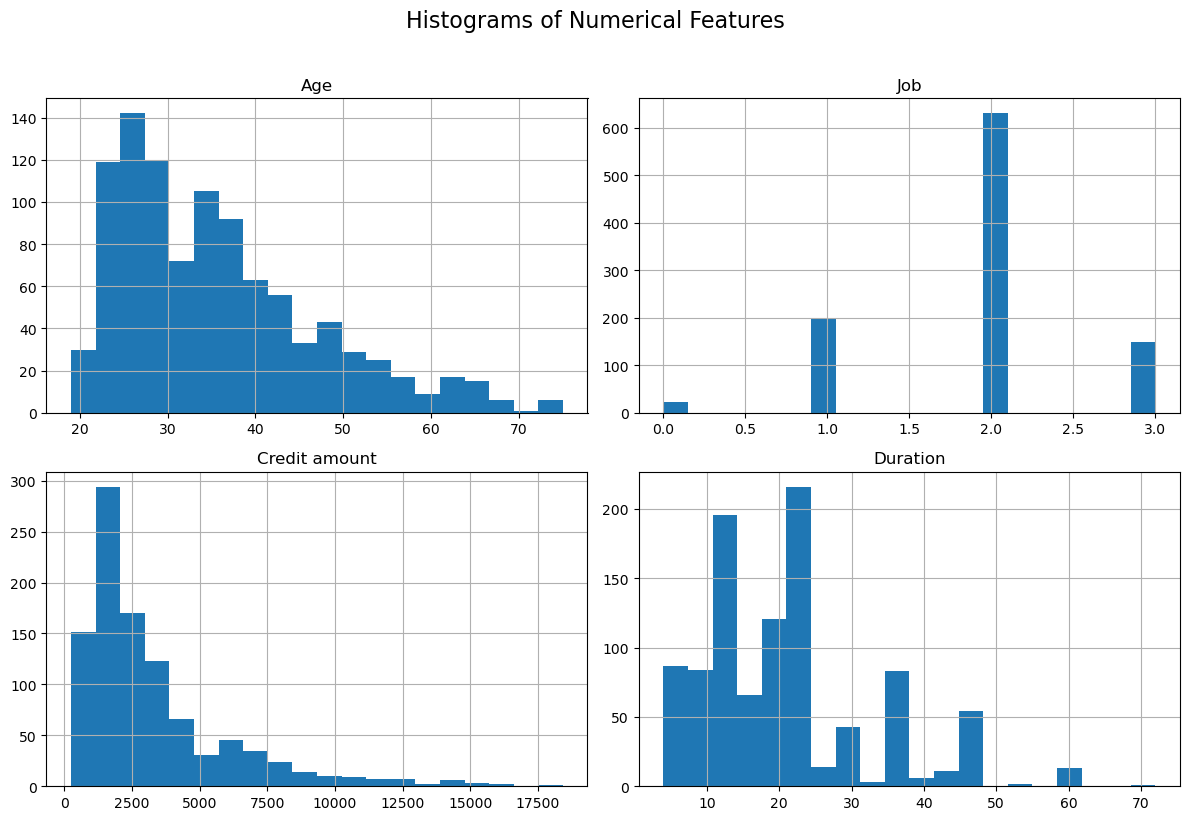

In [41]:
# Plot histograms for numerical features
german_credit_dataset[numerical_columns].hist(bins=20, figsize=(12,8))
py.suptitle("Histograms of Numerical Features", y=1.02, size=16)
py.tight_layout()
py.show()

In [42]:
from scipy.stats import skew

skewness = german_credit_dataset[numerical_columns].apply(lambda x: skew(x))

# Display skewness values
print("Skewness of Numerical Features:\n", skewness)

# Identify features with skewness greater than a threshold (e.g., 0.5)
skewed_features = skewness[abs(skewness) > 0.25].index


Skewness of Numerical Features:
 Age              1.019208
Job             -0.373733
Credit amount    1.946702
Duration         1.092542
dtype: float64


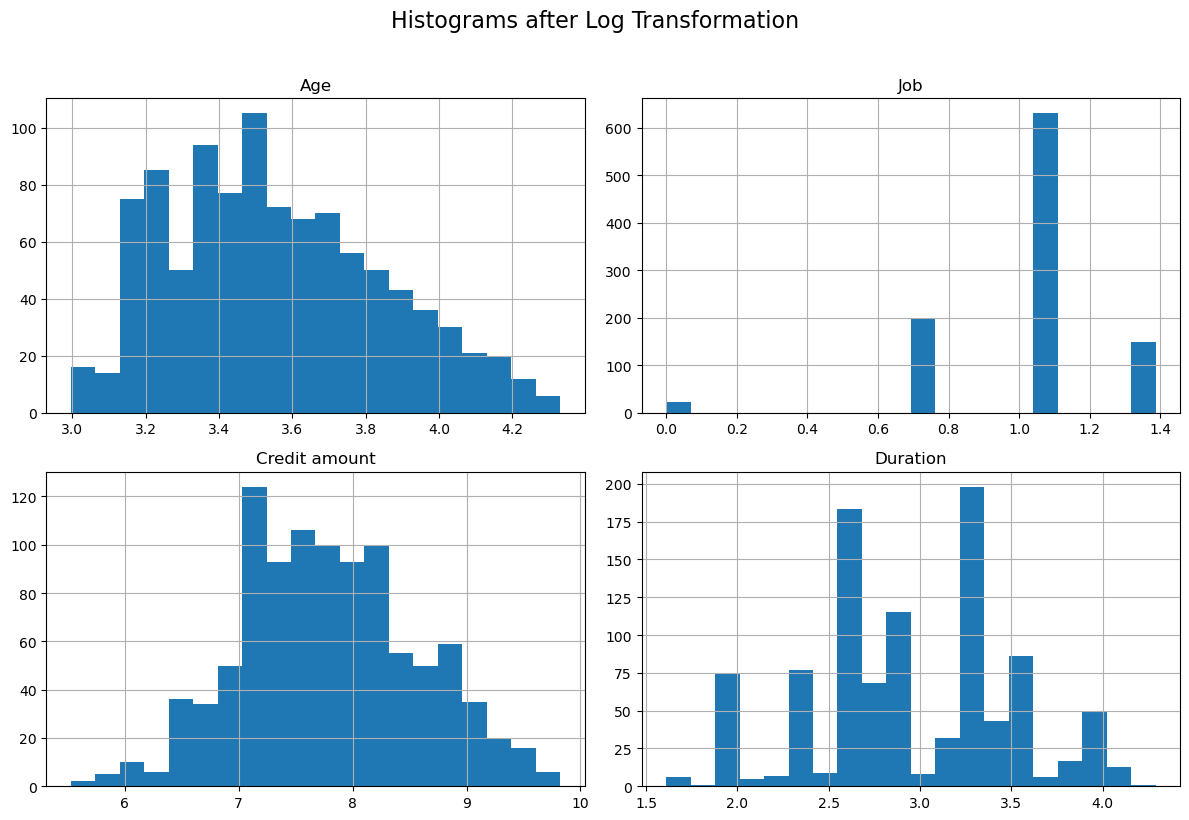

In [43]:
# Apply log transformation to skewed features
german_credit_dataset[skewed_features] = np.log1p(german_credit_dataset[skewed_features])

# Display histograms after log transformation
german_credit_dataset[skewed_features].hist(bins=20, figsize=(12,8))
py.suptitle("Histograms after Log Transformation", y=1.02, size=16)
py.tight_layout()
py.show()

## Applying Feature Scaling , Using MinMax Scaling on Numerical Columns

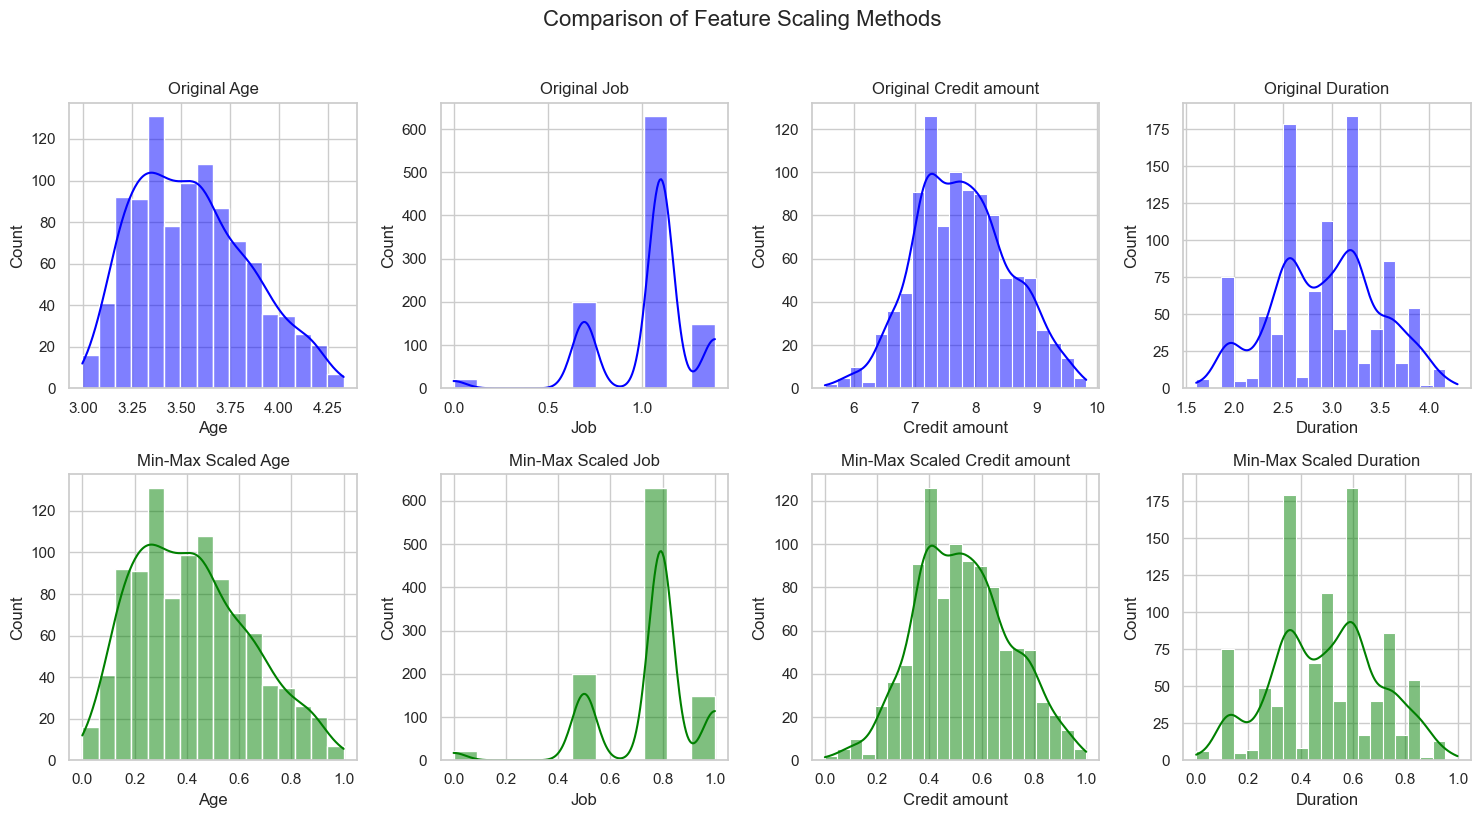

In [44]:
# Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler


min_max_scaler = MinMaxScaler()
german_credit_dataset_minmax = german_credit_dataset.copy()
german_credit_dataset_minmax[numerical_columns] = min_max_scaler.fit_transform(german_credit_dataset_minmax[numerical_columns])

# Set the style for Seaborn
snb.set(style="whitegrid")

# Create subplots using Seaborn
fig, axes = py.subplots(nrows=2, ncols=len(numerical_columns), figsize=(15, 8))
fig.suptitle("Comparison of Feature Scaling Methods", y=1.02, size=16)

# Plot original distributions with KDE plots
for i, col in enumerate(numerical_columns):
    snb.histplot(german_credit_dataset[col], kde=True, color='blue', ax=axes[0, i])
    axes[0, i].set_title(f"Original {col}")

# Plot distributions after Min-Max Scaling with KDE plots
for i, col in enumerate(numerical_columns):
    snb.histplot(german_credit_dataset_minmax[col], kde=True, color='green', ax=axes[1, i])
    axes[1, i].set_title(f"Min-Max Scaled {col}")

# Adjust layout
py.tight_layout()
py.show()

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

numerical_data = german_credit_dataset[numerical_columns]

# Standardize the numerical data (optional but often recommended for k-means)
scaler = StandardScaler()
numerical_data_standardized = scaler.fit_transform(numerical_data)

# Choose the number of clusters (you can adjust this)
num_clusters = 2

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(numerical_data_standardized)

# Add the cluster labels to the original dataset
german_credit_dataset['Cluster'] = clusters

# Print the updated dataset with cluster labels
print("Dataset with Cluster Labels:\n", german_credit_dataset[['Cluster'] + list(german_credit_dataset.columns[:-1])])

Dataset with Cluster Labels:
      Cluster       Age     Sex       Job Housing Saving accounts  \
0          1  4.219508    male  1.098612     own          little   
1          0  3.135494  female  1.098612     own          little   
2          1  3.912023    male  0.693147     own          little   
3          0  3.828641    male  1.098612    free          little   
4          0  3.988984    male  1.098612    free          little   
..       ...       ...     ...       ...     ...             ...   
995        1  3.465736  female  0.693147     own          little   
996        0  3.713572    male  1.386294     own          little   
997        1  3.663562    male  1.098612     own          little   
998        0  3.178054    male  1.098612    free          little   
999        0  3.332205    male  1.098612     own        moderate   

    Checking account  Credit amount  Duration              Purpose  Risk  
0             little       7.064759  1.945910             radio/TV  good  
1  

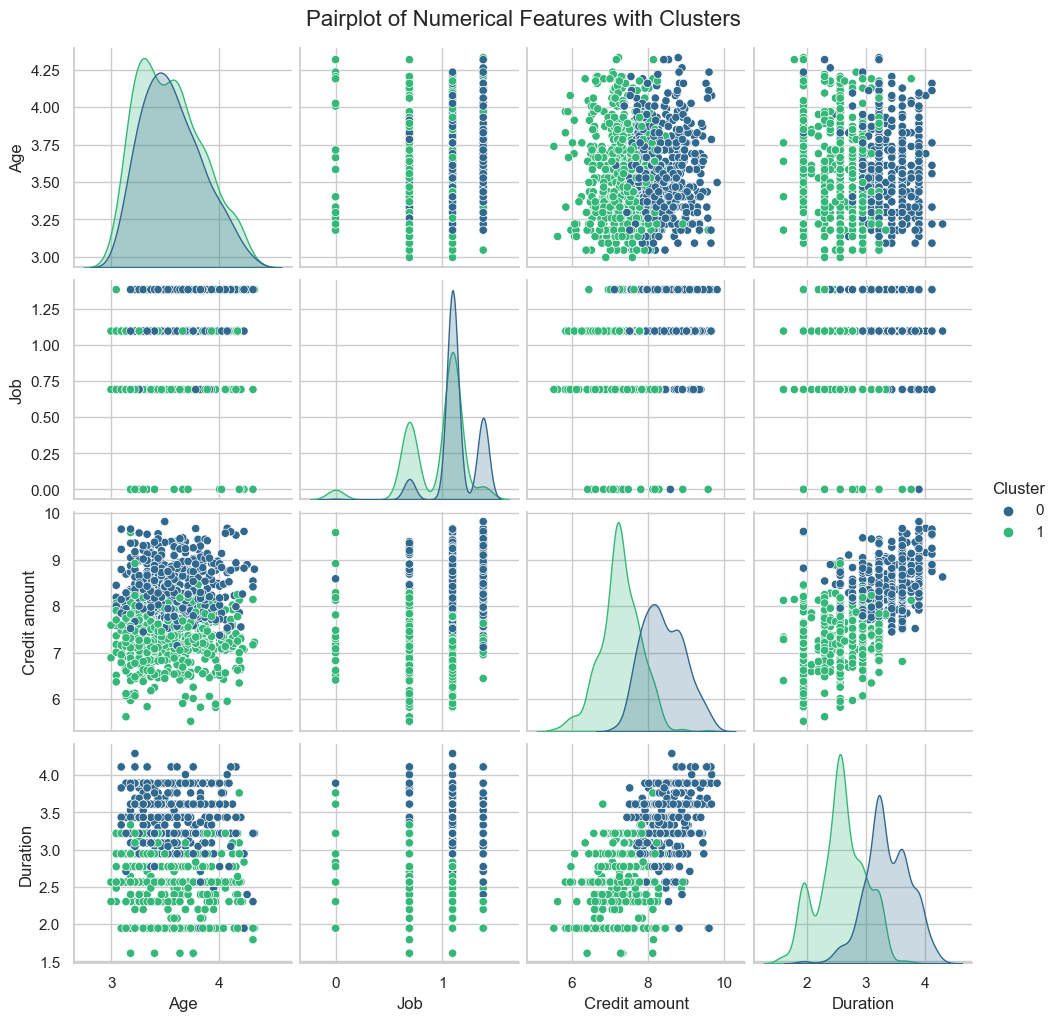

In [46]:
# Visualize the clusters
snb.set(style="whitegrid")
snb.pairplot(german_credit_dataset, hue='Cluster', palette='viridis', diag_kind='kde')
py.suptitle("Pairplot of Numerical Features with Clusters", y=1.02, size=16)
py.show()

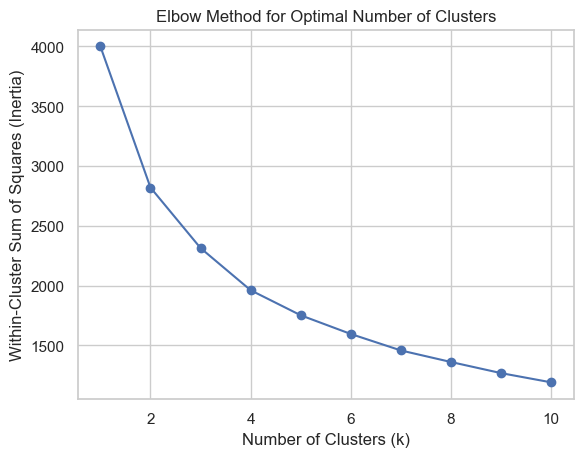

In [68]:
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(numerical_data_standardized)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow method graph with markers at potential elbow points
py.plot(range(1, 11), inertia_values, marker='o')
py.title('Elbow Method for Optimal Number of Clusters')
py.xlabel('Number of Clusters (k)')
py.ylabel('Within-Cluster Sum of Squares (Inertia)')
py.show()

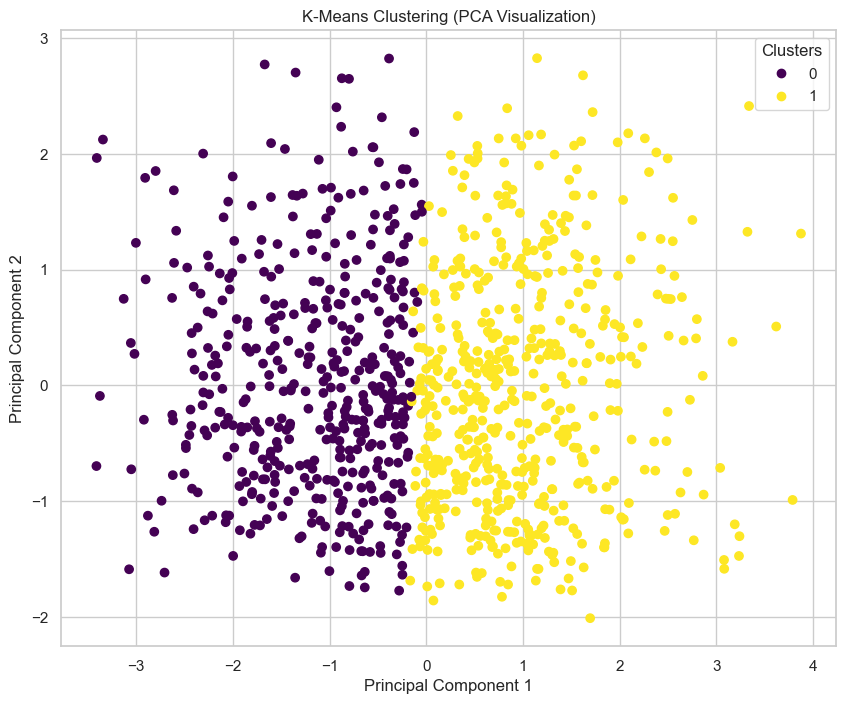

In [71]:
# Choose the optimum number of clusters (elbow point)
from sklearn.decomposition import PCA

optimal_k = 2  

# Perform k-means clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(numerical_data_standardized)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numerical_data_standardized)

# Visualize the clusters in 2D using PCA
py.figure(figsize=(10, 8))
scatter = py.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis')
py.title('K-Means Clustering (PCA Visualization)')
py.xlabel('Principal Component 1')
py.ylabel('Principal Component 2')
py.legend(*scatter.legend_elements(), title='Clusters')
py.show()

In [76]:
# Define your features (X) and target (y)
X = german_credit_dataset.drop(columns=['Risk'])
y = german_credit_dataset['Risk']

In [74]:
# RandomForestClassifier as estimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


estimator = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=7)

# Create RFECV with StratifiedKFold for cross-validation
rfecv = RFECV(estimator, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X, y)

# Plot the number of features vs. cross-validation score
py.figure()
py.title('RFECV - Number of Features vs. Cross-Validation Score')
py.xlabel('Number of Features Selected')
py.ylabel('Cross-Validation Score')
py.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
py.show()

# The optimal number of features can be obtained using rfecv.n_features_
print(f"Optimal number of features: {rfecv.n_features_}")

# Get the mean test scores during the feature selection process
mean_test_scores = rfecv.cv_results_['mean_test_score']

print("Number of steps in RFECV:", len(mean_test_scores))

ValueError: could not convert string to float: 'male'